In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

In [212]:
seed = 42

torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)
cuda = torch.cuda.is_available()
if cuda is True:
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [213]:
path = "Placement_Data_Full_Class.csv"

In [214]:
df = pd.read_csv(path)

In [215]:
df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [216]:
print("duplicates: ", df.duplicated(keep=False).sum())
print("imbalance count: \n", df['status'].value_counts())
print("\nimbalance ratio:\n", df['status'].value_counts(normalize=True))

duplicates:  0
imbalance count: 
 status
Placed        148
Not Placed     67
Name: count, dtype: int64

imbalance ratio:
 status
Placed        0.688372
Not Placed    0.311628
Name: proportion, dtype: float64


In [217]:
df.drop(["sl_no", "salary"], axis=1, inplace=True)

In [218]:
df['status'] = df['status'].map({'Placed': 1, 'Not Placed': 0})

In [219]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=seed, stratify=df["status"], shuffle=True)

In [220]:
y_train = df_train["status"]
x_train = df_train.drop(["status"], axis=1)

y_test = df_test["status"]
x_test = df_test.drop(["status"], axis=1)

In [221]:
#gender	ssc_p	ssc_b	hsc_p	hsc_b	hsc_s	degree_p	degree_t	workex	etest_p	specialisation	mba_p	status
cat_cols = ["gender", "ssc_b", "hsc_b", "hsc_s", "degree_t", "workex", "specialisation",]
num_cols = ["ssc_p", "hsc_p", "degree_p", "etest_p", "mba_p"]

preprocessing = ColumnTransformer([
	("cat", OneHotEncoder(), cat_cols), 
	("num", StandardScaler(), num_cols)
])

In [ ]:
pipe = Pipeline([
	("preprocessing", preprocessing),
	("rf", RandomForestClassifier(class_weight="balanced", random_state=seed))
])


In [223]:
pipe.fit(x_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['gender', 'ssc_b', 'hsc_b',
                                                   'hsc_s', 'degree_t',
                                                   'workex',
                                                   'specialisation']),
                                                 ('num', StandardScaler(),
                                                  ['ssc_p', 'hsc_p', 'degree_p',
                                                   'etest_p', 'mba_p'])])),
                ('rf', RandomForestClassifier(class_weight='balanced'))])

In [224]:
print(f"Train accuracy: {pipe.score(x_train, y_train)}")
print(f"Test accuracy: {pipe.score(x_test, y_test)}")

Train accuracy: 1.0
Test accuracy: 0.8372093023255814


In [225]:
probs = pipe.predict_proba(x_test)[:, 1]

In [226]:
ranking = probs.argsort()[::-1]
print(ranking)

[23 15  1 24  9 34 36  6  2 26  4 31 13  7 35 40 28 29  0 22 17 14 12  5
 11 25 10 18 27 30  3 38 16 32 37 41 21 42 39 20 33  8 19]


In [227]:
x_test.iloc[2]

gender                    M
ssc_p                  67.0
ssc_b                Others
hsc_p                  68.0
hsc_b                Others
hsc_s              Commerce
degree_p               64.0
degree_t          Comm&Mgmt
workex                  Yes
etest_p                74.4
specialisation       Mkt&HR
mba_p                 53.49
Name: 132, dtype: object

In [228]:
x_test.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p
63,M,61.0,Others,70.0,Others,Commerce,64.0,Comm&Mgmt,No,68.5,Mkt&HR,59.50
60,M,74.0,Central,70.0,Central,Science,72.0,Comm&Mgmt,Yes,60.0,Mkt&Fin,57.24
132,M,67.0,Others,68.0,Others,Commerce,64.0,Comm&Mgmt,Yes,74.4,Mkt&HR,53.49
75,F,59.0,Central,62.0,Others,Commerce,77.5,Comm&Mgmt,No,74.0,Mkt&HR,67.00
16,M,63.0,Central,66.2,Central,Commerce,65.6,Comm&Mgmt,Yes,60.0,Mkt&Fin,62.54


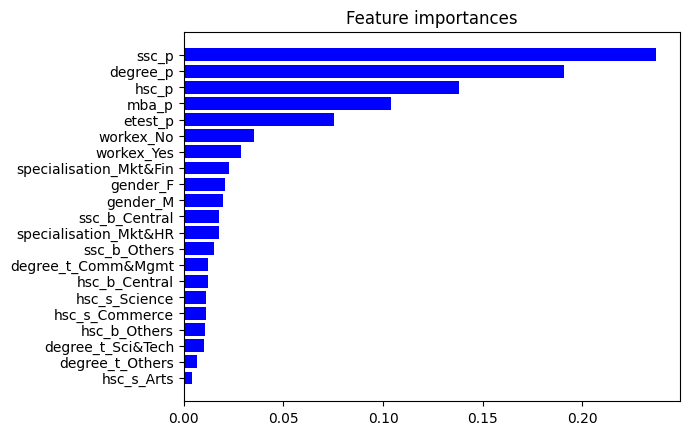

In [229]:
feature_importance = pipe["rf"].feature_importances_
feature_names = pipe["preprocessing"].get_feature_names_out()
feature_names = [name.replace("cat__", "") for name in feature_names]
feature_names = np.array([name.replace("num__", "") for name in feature_names])

sorted_idx = feature_importance.argsort()

#Plot the feature importance
plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx], color='blue')
plt.title("Feature importances")
plt.show()

In [ ]:
perm_imp_test = permutation_importance(pipe, x_test, y_test)

for i, feature in enumerate(x_test.columns):
  print(f"- {feature} => Mean: {perm_imp_test.importances_mean[i]:.4f} ; Std: {perm_imp_test.importances_std[i]:.4f}")

- gender => Mean: -0.0093 ; Std: 0.0114
- ssc_p => Mean: 0.0651 ; Std: 0.0451
- ssc_b => Mean: -0.0465 ; Std: 0.0208
- hsc_p => Mean: 0.0465 ; Std: 0.0360
- hsc_b => Mean: -0.0047 ; Std: 0.0093
- hsc_s => Mean: -0.0140 ; Std: 0.0114
- degree_p => Mean: 0.0279 ; Std: 0.0228
- degree_t => Mean: -0.0233 ; Std: 0.0147
- workex => Mean: -0.0047 ; Std: 0.0174
- etest_p => Mean: -0.0186 ; Std: 0.0093
- specialisation => Mean: -0.0093 ; Std: 0.0114
- mba_p => Mean: 0.0047 ; Std: 0.0174


In [233]:
perm_imp_train = permutation_importance(pipe, x_train, y_train)

for i, feature in enumerate(x_train.columns):
  print(f"- {feature} => Mean: {perm_imp_test.importances_mean[i]:.4f} ; Std: {perm_imp_test.importances_std[i]:.4f}")

- gender => Mean: -0.0093 ; Std: 0.0114
- ssc_p => Mean: 0.0651 ; Std: 0.0451
- ssc_b => Mean: -0.0465 ; Std: 0.0208
- hsc_p => Mean: 0.0465 ; Std: 0.0360
- hsc_b => Mean: -0.0047 ; Std: 0.0093
- hsc_s => Mean: -0.0140 ; Std: 0.0114
- degree_p => Mean: 0.0279 ; Std: 0.0228
- degree_t => Mean: -0.0233 ; Std: 0.0147
- workex => Mean: -0.0047 ; Std: 0.0174
- etest_p => Mean: -0.0186 ; Std: 0.0093
- specialisation => Mean: -0.0093 ; Std: 0.0114
- mba_p => Mean: 0.0047 ; Std: 0.0174


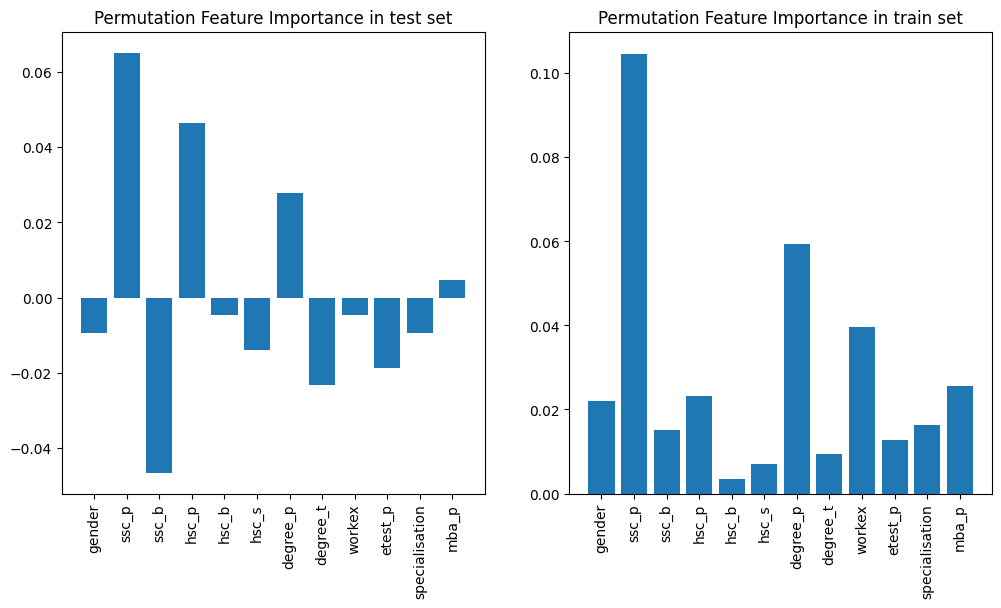

In [234]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(x_test.shape[1]), perm_imp_test.importances_mean)
plt.xticks(range(x_test.shape[1]), x_test.columns, rotation=90)
plt.title("Permutation Feature Importance in test set")

plt.subplot(1, 2, 2)
plt.bar(range(x_train.shape[1]), perm_imp_train.importances_mean)
plt.xticks(range(x_train.shape[1]), x_train.columns, rotation=90)
plt.title("Permutation Feature Importance in train set")

plt.show()